In [ ]:
%pip install gymnasium
%pip install gymnasium[toy-text]
%pip install pygame
%pip install seaborn

In [7]:
import time
import random
import os

import numpy as np
np.set_printoptions(precision=3)
np.random.seed(42)

import gymnasium as gym
import pygame

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
if not os.path.isdir("./q_tables/"):
    os.mkdir("./q_tables/")

In [9]:
env = gym.make("FrozenLake-v1", render_mode='human') #move up a cell to not waste time

In [10]:
#Test game with random actions
cur_state = env.reset() # reset environment and get initial state
ret = 0.
done = False
i = 0
while not done:
    action = env.action_space.sample() # sample an action randomly
    next_state, reward, done, truncated, info = env.step(action)
    ret += reward
    cur_state = next_state
    time.sleep(0.01)
    i += 1

    if i == 50:
        pygame.quit()
        break

In [11]:
def init_q_table():
    return np.zeros([env.observation_space.n, env.action_space.n])

In [12]:
def epsilon_greedy_policy(q_table, current_state, epsilon):
    if random.random() < epsilon:
        action = env.action_space.sample() #exploration
    else:
        action = np.argmax(q_table[current_state]) #exploitation
    return action

In [13]:
def greedy_policy(q_table, current_state):
    action = np.argmax(q_table[current_state])
    return action

In [14]:
def train(q_table, gamma, alpha, epsilon, iterations, name):
    start_time = time.time()
    
    env = gym.make("FrozenLake-v1")

    epochs_total = []
    rewards_total = []
    
    for i in range(iterations):
        current_state = env.reset()[0]

        epochs, reward, rewards = 0, 0, 0
        done = False

        while not done:
            action = epsilon_greedy_policy(q_table, current_state, epsilon)
            next_state, reward, done, truncated, info = env.step(action)

            q_table[current_state][action] = q_table[current_state][action] + \
                alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[current_state][action])

            rewards += reward 
            current_state = next_state

            epochs += 1

        epochs_total.append(epochs)
        rewards_total.append(rewards)


        if i % 1000 == 0:
            print(f"Episode: {i}, rewards:{rewards}")
    
    runtime = time.time() - start_time

    print("Training finished.\n")
    
    #save trained q_table
    np.save(f"./q_tables/{name}.npy", q_table)
    
    #logging stuff
    avg_reward = np.average(rewards_total)
    max_reward = max(rewards_total)
    min_reward = min(rewards_total)
    
    with open(f"./q_logging.txt", "a") as f:
        f.write(f"Epsilon:{epsilon}, gamma:{gamma}, alpha:{alpha}, avg_reward: {avg_reward}, max_reward: {max_reward}, min_reward:{min_reward}, runtime: {runtime}\n")
    
    return q_table, epochs_total, rewards_total

In [15]:
#play a game with trained q_table
def play_game(q_table):
    time.sleep(2)

    env = gym.make("FrozenLake-v1", render_mode="human")

    state = env.reset()[0]
    done = False

    while not done:
        time.sleep(0.1)
        action = np.argmax(q_table[state])
        state, reward, done, truncated, info = env.step(action)

    pygame.quit()  

In [16]:
def plot_epochs_rewards(epochs_total, rewards_total):
    plt.figure(1)
    
    plt.subplot(211)
    plt.plot(epochs_total)
    plt.title('Evolution of number of steps')
    plt.ylabel('Number of steps')
    plt.xlabel('epsiode')
    
    plt.subplot(212)
    plt.plot(rewards_total,'r')
    plt.title('Evolution of total reward')
    plt.ylabel('Rewards')
    plt.xlabel('epsiode')
    plt.show()

## Default params

In [17]:
#Default hyperpram

# gamma discount factor
gamma = 0.9
# alpha learning rate
alpha = 0.1
# epsilon greedy exploration parameter
epsilon = 0.5
#max steps per episode
iterations = 3000

In [18]:
#train
default_val_table = init_q_table()
default_val_table, epochs_total, rewards_total = train(default_val_table, gamma, alpha, epsilon, iterations, "default params")

Episode: 0, rewards:0.0
Episode: 1000, rewards:0.0
Episode: 2000, rewards:0.0
Training finished.



In [23]:
print(f"Total rewards after 3k episodes: {sum(rewards_total)}")

Total rewards after 3k episodes: 132.0


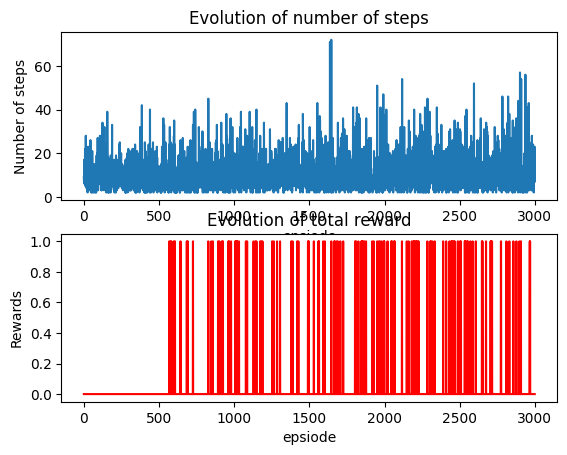

In [22]:
plot_epochs_rewards(epochs_total, rewards_total)

In [25]:
play_game(default_val_table)

<p>Here we see the agent trying the moves he knows are safe quite often but he will try a new (unsafe) move and this results in learning how to do the level.</p>

## Low epsilon

In [24]:
#train with low epsilon
epsilon = 0.1
low_epsilon_q_table = init_q_table()
low_epsilon_q_table, epochs_total, rewards_total = train(low_epsilon_q_table, gamma, alpha, epsilon, iterations, "low_epsilon")

Episode: 0, rewards:0.0
Episode: 1000, rewards:0.0
Episode: 2000, rewards:0.0
Training finished.



In [25]:
print(f"Total rewards after 3k episodes: {sum(rewards_total)}")

Total rewards after 3k episodes: 0.0


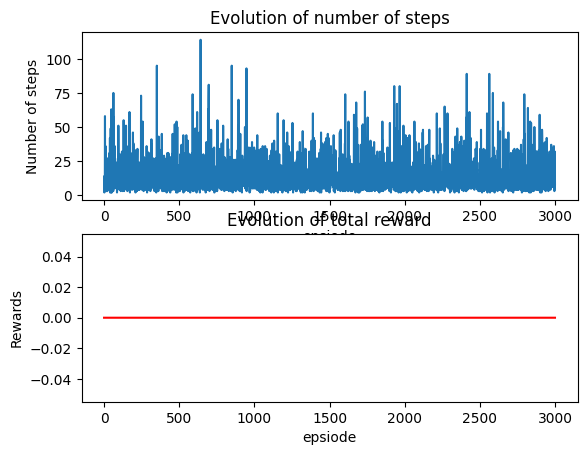

In [26]:
plot_epochs_rewards(epochs_total, rewards_total)

In [17]:
play_game(low_epsilon_q_table)

<p>Here we see that the agent doesn't really go further than the one move he knows (1 tile down) this is exactly what you'd expect from setting a very low epsilon meaning that the agent doesn't explore and thus won't learn. This is clearly indicated in the reward graph staying a constant 0</p>

## High epsilon

In [27]:
#train with high epsilon
epsilon = 1
high_epsilon_q_table = init_q_table()
high_epsilon_q_table, epochs_total, rewards_total = train(high_epsilon_q_table, gamma, alpha, epsilon, iterations, "high_epsilon")

Episode: 0, rewards:0.0
Episode: 1000, rewards:0.0
Episode: 2000, rewards:0.0
Training finished.



In [28]:
print(f"Total rewards after 3k episodes: {sum(rewards_total)}")

Total rewards after 3k episodes: 33.0


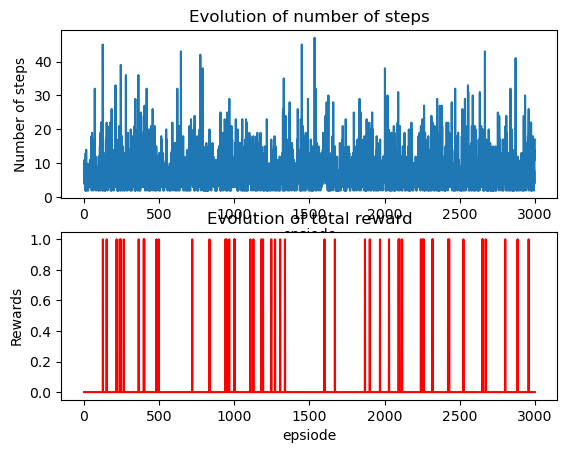

In [28]:
plot_epochs_rewards(epochs_total, rewards_total)

In [24]:
play_game(high_epsilon_q_table)

<p>In this case the epsilon is really high so the agent only tries new things without exploiting known moves, this translates well into the reward graph where we can see that the agent only occasionally finishes the level (when he gets luck) but doesn't learn how to do it<p>

## Epsilon decay

In [29]:
#hyperparam
epsilon = 1
decay = 0.001
min_epsilon = 0.01

In [30]:
def train_with_decay(q_table, gamma, alpha, epsilon, iterations, name, decay, min_epsilon):
    start_time = time.time()
    
    env = gym.make("FrozenLake-v1")

    epochs_total = []
    rewards_total = []
    
    for i in range(iterations):
        current_state = env.reset()[0]

        epochs, reward, rewards = 0, 0, 0
        done = False

        while not done:
            action = epsilon_greedy_policy(q_table, current_state, epsilon)
            next_state, reward, done, truncated, info = env.step(action)

            q_table[current_state][action] = q_table[current_state][action] + \
                alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[current_state][action])

            rewards += reward 
            current_state = next_state

            epochs += 1
        
        epsilon = max(min_epsilon, epsilon - decay) #added epsilon decay

        epochs_total.append(epochs)
        rewards_total.append(rewards)


        if i % 1000 == 0:
            print(f"Episode: {i}, rewards:{rewards}")
    
    runtime = time.time() - start_time

    print("Training finished.\n")
    
    #save trained q_table
    np.save(f"./q_tables/{name}.npy", q_table)
    
    #logging stuff
    avg_reward = np.average(rewards_total)
    max_reward = max(rewards_total)
    min_reward = min(rewards_total)
    
    with open(f"./q_logging.txt", "a") as f:
        f.write(f"Epsilon:{epsilon}, gamma:{gamma}, alpha:{alpha}, avg_reward: {avg_reward}, max_reward: {max_reward}, min_reward:{min_reward}, runtime: {runtime}\n")
    
    return q_table, epochs_total, rewards_total

In [31]:
#train with high epsilon
decay_q_table = init_q_table()
decay_q_table, epochs_total, rewards_total = train_with_decay(decay_q_table, gamma, alpha, epsilon, iterations, "epsilon decay", decay, min_epsilon)

Episode: 0, rewards:0.0
Episode: 1000, rewards:0.0
Episode: 2000, rewards:1.0
Training finished.



In [32]:
print(f"Total rewards after 3k episodes: {sum(rewards_total)}")

Total rewards after 3k episodes: 1110.0


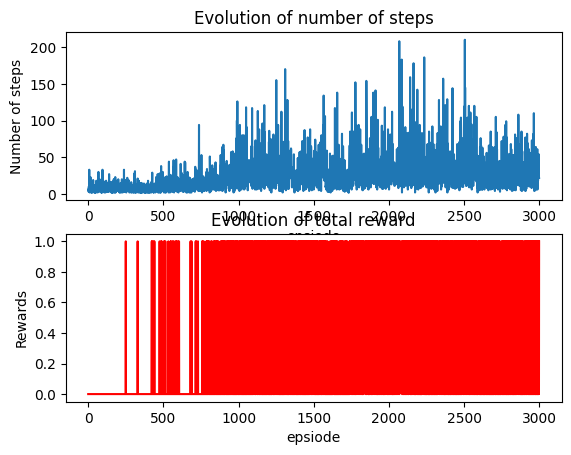

In [33]:
plot_epochs_rewards(epochs_total, rewards_total)

In [32]:
play_game(decay_q_table)

<p>Judging from the game I watched and the reward graph/ logging stats we can see that this method works a lot better. The average reward is almost 10x the second best average reward (default param) and the reward graph shows that the agent is a lot more consistent in completing the level after it has trained for a bit. <br> It seems logical that letting the agent learn a lot in the beginning via exploration and when the agent has learned enough focus more on exploiting is a more efficient way of learning</p>

In [36]:
episodes =  [i for i in range(0,3000)]

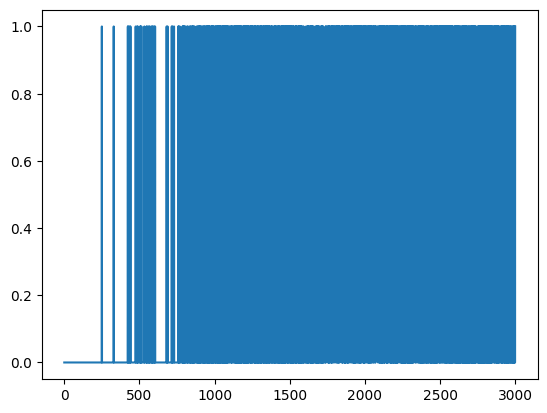

In [37]:
plt.plot(episodes, rewards_total)

## Environment

## Heatmap of traversed cells

In [236]:
def train_with_action_logging(q_table, gamma, alpha, epsilon, iterations, name, action_log):
    start_time = time.time()
    
    env = gym.make("FrozenLake-v1")

    epochs_total = []
    rewards_total = []
    
    for i in range(iterations):
        
        current_state = env.reset()[0]

        epochs, reward, rewards = 0, 0, 0
        done = False
        action_per_game = []
        while not done:
            action = epsilon_greedy_policy(q_table, current_state, epsilon)
            action_per_game.append(action)
            next_state, reward, done, truncated, info = env.step(action)

            q_table[current_state][action] = q_table[current_state][action] + \
                alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[current_state][action])

            rewards += reward 
            current_state = next_state

            epochs += 1

        epochs_total.append(epochs)
        rewards_total.append(rewards)

        action_log.append(action_per_game)
        
        if i % 1000 == 0:
            print(f"Episode: {i}, rewards:{rewards}")
    
    runtime = time.time() - start_time

    print("Training finished.\n")
    
    #save trained q_table
    np.save(f"./q_tables/{name}.npy", q_table)
    
    #logging stuff
    avg_reward = np.average(rewards_total)
    max_reward = max(rewards_total)
    min_reward = min(rewards_total)
    
    with open(f"./q_logging.txt", "a") as f:
        f.write(f"Epsilon:{epsilon}, gamma:{gamma}, alpha:{alpha}, avg_reward: {avg_reward}, max_reward: {max_reward}, min_reward:{min_reward}, runtime: {runtime}\n")
    
    return q_table, epochs_total, rewards_total

In [268]:
action_log = []

In [269]:
# gamma discount factor
gamma = 0.9
# alpha learning rate
alpha = 0.1
# epsilon greedy exploration parameter
epsilon = 0.5
#max steps per episode
iterations = 3000

default_val_table = init_q_table()
default_val_table, epochs_total, rewards_total = train_with_action_logging(default_val_table, gamma, alpha, epsilon, iterations, "default params", action_log)

Episode: 0, rewards:0.0
Episode: 1000, rewards:1.0
Episode: 2000, rewards:0.0
Training finished.



In [270]:
GAME_GRID = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
GAME_GRID

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

In [271]:
def next_move(step, cur_row, cur_col):
    if step == 0:
        return cur_row, cur_col-1
    if step == 1:
        return cur_row+1, cur_col
    if step == 2:
        return cur_row, cur_col+1
    if step == 3:
        return cur_row-1, cur_col

In [272]:
def map_step(step):
    if step == 0:
        return "left"
    if step == 1:
        return "down"
    if step == 2:
        return 'right'
    if step == 3:
        return "up"

In [275]:
for game in action_log:
    cur_col, cur_row = 0, 0
    for step in game:
        
        row, col = next_move(step, cur_row, cur_col)
        
        if col <= 3 and col >= 0:
            cur_col = col
        
        if row <= 3 and row >= 0:
            cur_row = row
        
        GAME_GRID[cur_row][cur_col] += 1

<Axes: >

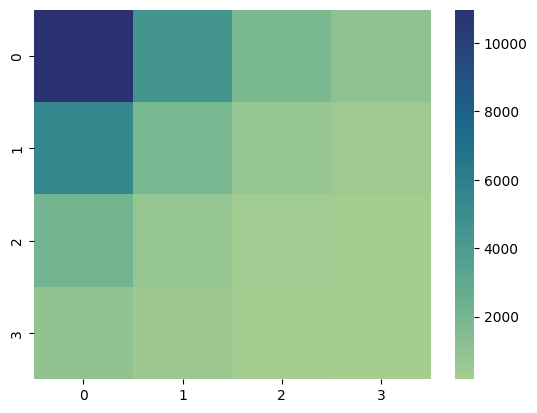

In [274]:
import seaborn as sns
sns.heatmap(GAME_GRID, cmap="crest")